In [145]:

import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
# from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

torch.set_default_dtype(torch.float)
torch.manual_seed(1234)
np.random.seed(1234)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
    print(torch.cuda.get_device_name())

cpu


In [146]:
## Paramaters
steps=50000
lr=1e-3
total_points=500
min=0
max=5
a_true = 3
N_u= 100
N_f=250
layers = np.array([1,50,50,1]) #5 hidden layers

def f_BC(t):
 return torch.exp(a_true *t)

In [147]:
# Parameters for equation

def grad(function,var):
    return autograd.grad(function, var, grad_outputs=torch.ones_like(function), create_graph=True, retain_graph=True)[0]



class PINN(nn.Module):

    def __init__(self):
        super(PINN, self).__init__()



        # self.input = nn.Linear(1, 20)
        # self.hidden = nn.Linear(20, 20)
        # self.out = nn.Linear(20, 1)

        self.activation = nn.Tanh()
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0

        # training

    def forward(self, x):
        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)
        layer = x.float()
        for i in range(len(layers)-2):
            z = self.linears[i](layer)
            layer = self.activation(z)
        layer = self.linears[-1](layer)
        return layer
        # if torch.is_tensor(x) != True:
        #     x = torch.from_numpy(x)
        # a = x.float()
        # x = self.hidden(x)
        # x = self.activation(x)

        # x = self.hidden(x)
        # x = self.activation(x)


        # x = self.out(x)
        # return x

    # We are using a simple exponential equation to test the PINN

    def LossData(self,t,y_meas):
        loss_bc = torch.mean((self.forward(t) - y_meas)**2)
        return loss_bc

    def LossPDE(self,t):

        temp = t.clone()
        temp.requires_grad = True

        u = self.forward(temp)
        u_t = autograd.grad(u,temp,grad_outputs=torch.ones_like(u),create_graph=True)[0]
        # u_t = grad(u,t)

        eq1 = u_t - a*u
        # print("eq1 data type: ",type(eq1))
        loss_PDE = torch.mean(eq1**2)
        return loss_PDE
    
    def LossICD(self,t):
        initial_t = torch.zeros(100, device=t.device).reshape(-1, 1)
        initial_condition = self.forward(initial_t) - 1.0
        loss_ics = torch.mean(initial_condition**2)
        return loss_ics

    def LossComb(self,t,y_meas):
        loss_bc = self.LossData(t,y_meas)
        loss_pde = self.LossPDE(t)
        loss_ics = self.LossICD(t)

        # print("bc data type: ",type(loss_bc))
        # print("pde data type: ",type(loss_pde))

        return loss_bc + loss_pde + loss_ics



In [148]:
# get the analytical solution over the full domain
t_vals = torch.linspace(min,max,total_points,device = device).reshape(-1, 1) #prepare to NN
y_true = f_BC(t_vals)
print(t_vals.shape, y_true.shape)


torch.Size([500, 1]) torch.Size([500, 1])


In [149]:
# Construct trainning data

total_points = len(t_vals)
id_f = np.random.choice(total_points, N_f, replace=False)# Randomly chosen points for Interior
id_f = np.sort(id_f)
t_train = t_vals[id_f]
y_train= y_true[id_f]

t_test = torch.linspace(0, 1, 100, device=device).reshape(-1, 1)
t_plot = t_test.detach().cpu().numpy()
y_plot = f_BC(t_test).detach().cpu().numpy()
print(np.shape(t_plot))
print("We have",total_points,"points. We will select",t_train.shape[0],"points to train our model.")

print(y_train)

(100, 1)
We have 500 points. We will select 250 points to train our model.
tensor([[1.0000e+00],
        [1.1976e+00],
        [1.2342e+00],
        [1.3107e+00],
        [1.3919e+00],
        [1.4781e+00],
        [1.8243e+00],
        [1.8800e+00],
        [1.9374e+00],
        [1.9965e+00],
        [2.0574e+00],
        [2.1202e+00],
        [2.2516e+00],
        [2.3911e+00],
        [2.5392e+00],
        [2.6966e+00],
        [2.9511e+00],
        [3.0411e+00],
        [3.3281e+00],
        [3.5343e+00],
        [3.6422e+00],
        [3.7533e+00],
        [4.6324e+00],
        [4.7737e+00],
        [5.0695e+00],
        [5.2242e+00],
        [5.5479e+00],
        [5.7172e+00],
        [5.8917e+00],
        [6.8473e+00],
        [7.2715e+00],
        [7.4934e+00],
        [7.9578e+00],
        [8.2006e+00],
        [8.4509e+00],
        [8.9745e+00],
        [9.2484e+00],
        [1.0121e+01],
        [1.0430e+01],
        [1.1076e+01],
        [1.4960e+01],
        [1.5417e+01],
 

In [150]:

#Create Model
model = PINN().to(device)

a = torch.tensor([1.1], requires_grad=True, device=device)

params = list(model.parameters())
# params.append(a)
optimizer = torch.optim.Adam(params+[a],lr=lr,amsgrad=False)
start_time = time.time()

Epoch 0, Loss: 383001100288.000000, Estimated a: 1.099000
PDE LOSS:  0.00843053963035345
Data LOSS:  383001034752.0
Epoch 1000, Loss: 382974492672.000000, Estimated a: 0.100436
PDE LOSS:  519.1357421875
Data LOSS:  382974459904.0
Epoch 2000, Loss: 382950309888.000000, Estimated a: 0.112316
PDE LOSS:  1369.27587890625
Data LOSS:  382950309888.0
Epoch 3000, Loss: 382926192640.000000, Estimated a: 0.133384
PDE LOSS:  1818.8062744140625
Data LOSS:  382926127104.0
Epoch 4000, Loss: 382902075392.000000, Estimated a: 0.142606
PDE LOSS:  3130.02294921875
Data LOSS:  382902042624.0
Epoch 5000, Loss: 382878023680.000000, Estimated a: 0.147418
PDE LOSS:  4790.76220703125
Data LOSS:  382877958144.0
Epoch 6000, Loss: 382853906432.000000, Estimated a: 0.151078
PDE LOSS:  6928.998046875
Data LOSS:  382853906432.0
Epoch 7000, Loss: 382829821952.000000, Estimated a: 0.152052
PDE LOSS:  9148.099609375
Data LOSS:  382829821952.0
Epoch 8000, Loss: 382805835776.000000, Estimated a: 0.134297
PDE LOSS:  1067

KeyboardInterrupt: 

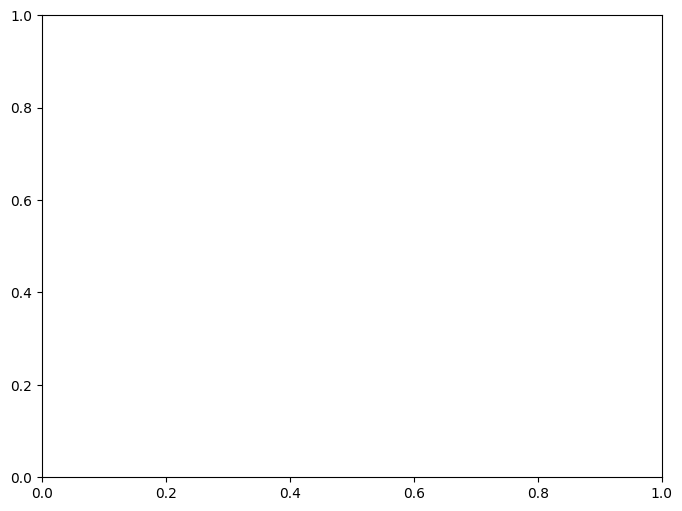

In [151]:
plt.ion()
fig, ax = plt.subplots(figsize=(8, 6))

for i in range(steps):
    yh = model(t_train)
    loss = model.LossComb(t_train,y_train)# use mean squared error
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%(steps/50)==0:
      print(f"Epoch {i}, Loss: {loss.item():.6f}, Estimated a: {a.item():.6f}")
      print("PDE LOSS: ",model.LossPDE(t_train).item())
      print("Data LOSS: ",model.LossData(t_train,y_train).item())

      # y_pred = model(t_test).detach().cpu().numpy()
      # ax.plot(t_plot, y_plot, label="Exact Solution $y(t) = e^{3t}$", linestyle="--")
      # ax.plot(t_plot, y_pred, label="PINN Approximation", linestyle="-")
      # ax.set_xlabel("Time $t$")
      # ax.set_ylabel("$y(t)$")
      # ax.set_title(f"PINN Solution vs Exact Solution\nEstimated a: {a.item():.4f}, Epoch: {i}")
      # ax.legend()
      # ax.grid(True)
      # plt.pause(0.01)  # Pause to update the figure 
      # ax.clear()  # Clear previous plots
plt.ioff()
plt.show()

In [ ]:
yh=model(x.to(device))
y=f_BC(x)
#Error
print(model.LossBC(x.to(device)))

tensor(0.0590, grad_fn=<MeanBackward0>)


In [ ]:
# Derivative
g=x.to(device)
g=g.clone()
g.requires_grad=True #Enable differentiation
f=model(g)
f_x=autograd.grad(f,g,torch.ones([g.shape[0],1]).to(device),retain_graph=True, create_graph=True)[0]

In [ ]:
y_plot=y.detach().numpy()
yh_plot=yh.detach().cpu().numpy()
f_x_plot=f_x.detach().cpu().numpy()


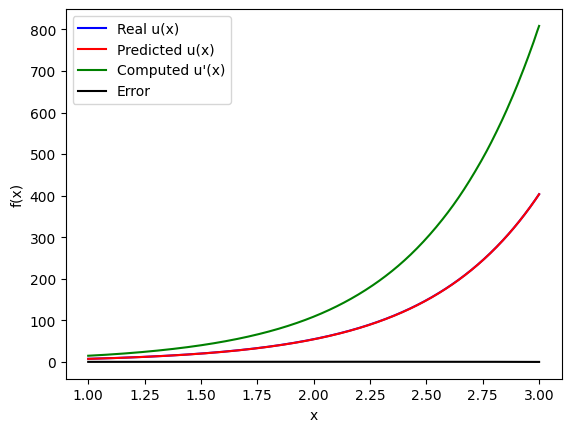

In [ ]:
# Plot
fig, ax1 = plt.subplots()
ax1.plot(x,y_plot,color='blue',label='Real u(x)')
ax1.plot(x,yh_plot,color='red',label='Predicted u(x)')
ax1.plot(x,f_x_plot,color='green',label='Computed u\'(x)')
ax1.plot(x,y_plot-yh_plot,color='black',label='Error')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')


In [ ]:
#def get_training_data(x):
#Nu: Number of training point, # Nf: Number of colloction points
# Set Boundary conditions:
t_vals = torch.linspace(min,max,total_points).view(-1,1) #prepare to NN
y_true = f_BC(t_vals)
print(t_vals.shape, y_true.shape)

BC_1=t_vals[0,:]
BC_2=t_vals[-1,:]
# Total Training points BC1+BC2
all_train=torch.vstack([BC_1,BC_2])
#Select Nu points
idx = np.random.choice(all_train.shape[0], N_u, replace=False)
x_BC=all_train[idx]
#Select Nf points
# Latin Hypercube sampling for collocation points
x_PDE = BC_1 + (BC_2-BC_1)*lhs(1,N_f)
x_PDE = torch.vstack((x_PDE,x_BC))

x_PDE.shape

torch.Size([500, 1]) torch.Size([500, 1])


ValueError: Cannot take a larger sample than population when 'replace=False'

NameError: name 'x_PDE' is not defined

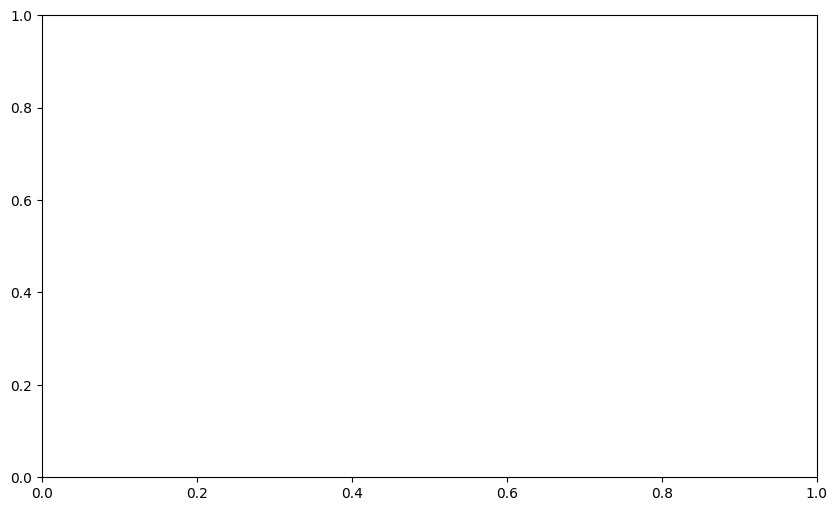

In [ ]:
#Store tensors to GPU

plt.ion()
fig, ax = plt.subplots(figsize=(10, 6))

x_PDE=x_PDE.float().to(device)
x_BC=x_BC.to(device)
#Create Model
a = torch.tensor([1.0], requires_grad=True, device=device)
model = PINN()
print(model)
model.to(device)
params = list(model.parameters()+[a])
optimizer = torch.optim.Adam(model.parameters(),lr=lr,amsgrad=False)
start_time = time.time()

In [ ]:
#Training
for i in range(steps):
    yh = model(x_PDE)
    loss = model.LossComb(x_PDE,x_BC)# use mean squared error
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%(steps/10)==0:
      print(f"Epoch {epoch}, Loss: {loss.item():.6f}, Estimated a: {a.item():.6f}")

      # Update the plot every (num_epoch // 10) epochs
      y_pred = model(t_test).detach().cpu().numpy()
      ax.plot(t_vals, y_true, label="Exact Solution $y(t) = e^{3t}$", linestyle="--")
      ax.plot(t_vals, y_pred, label="PINN Approximation", linestyle="-")
      ax.set_xlabel("Time $t$")
      ax.set_ylabel("$y(t)$")
      ax.set_title(f"PINN Solution vs Exact Solution\nEstimated a: {a.item():.4f}, Epoch: {epoch}")
      ax.legend()
      ax.grid(True)
      plt.pause(0.01)  # Pause to update the figure ax.clear()  # Clear previous plots
      print(loss)

tensor(81472.1094, grad_fn=<AddBackward0>)
tensor(14062.3750, grad_fn=<AddBackward0>)
tensor(67.4583, grad_fn=<AddBackward0>)
tensor(0.0512, grad_fn=<AddBackward0>)
tensor(0.0301, grad_fn=<AddBackward0>)
tensor(0.0165, grad_fn=<AddBackward0>)
tensor(0.0106, grad_fn=<AddBackward0>)
tensor(0.5777, grad_fn=<AddBackward0>)
tensor(0.0182, grad_fn=<AddBackward0>)
tensor(0.0115, grad_fn=<AddBackward0>)


In [ ]:
yh=model(x.to(device))
y=f_BC(x)
#Error
print(model.LossBC(x.to(device)))

tensor(0.0590, grad_fn=<MeanBackward0>)


In [ ]:
# Derivative
g=x.to(device)
g=g.clone()
g.requires_grad=True #Enable differentiation
f=model(g)
f_x=autograd.grad(f,g,torch.ones([g.shape[0],1]).to(device),retain_graph=True, create_graph=True)[0]

In [ ]:
y_plot=y.detach().numpy()
yh_plot=yh.detach().cpu().numpy()
f_x_plot=f_x.detach().cpu().numpy()


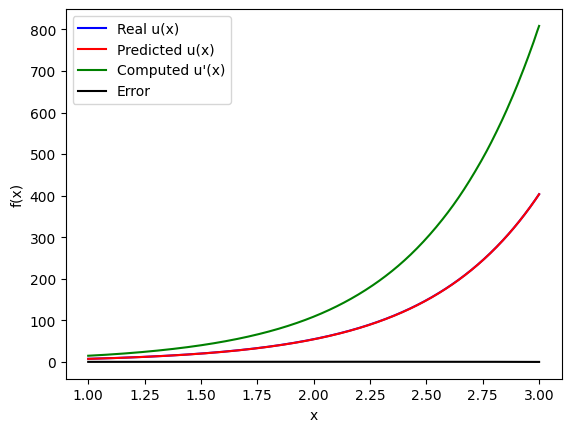

In [ ]:
# Plot
fig, ax1 = plt.subplots()
ax1.plot(x,y_plot,color='blue',label='Real u(x)')
ax1.plot(x,yh_plot,color='red',label='Predicted u(x)')
ax1.plot(x,f_x_plot,color='green',label='Computed u\'(x)')
ax1.plot(x,y_plot-yh_plot,color='black',label='Error')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')
